In [1]:
%load_ext autoreload

In [291]:
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from src.utils import load_train_test, load_val, load_val_dates
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

sns.set_theme(style="darkgrid")

In [79]:
def create_time_feature(df):
    df['hour'] = df.index.hour
    df['dayofmonth'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [406]:
X_train, y_train, X_test, y_test = load_train_test("A")
nan_columns = X_train.columns[X_train.isna().any()].tolist()
# Step2: Drop those indices
X_train = X_train.drop(columns=nan_columns)
X_test = X_test.drop(columns=nan_columns)


X_val = load_val("A")

train_time_features = create_time_feature(X_train.copy())
test_time_features = create_time_feature(X_test.copy())

model = xgb.XGBRegressor(eval_metric="mae")

param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'eta': [0.005, 0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'min_child_weight': [1, 2, 3, 4, 5],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 1, 10],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_lambda': [0, 0.01, 0.1, 1, 10],
    'booster': ['gbtree', 'gblinear', 'dart']
}

# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
# grid_search.fit(X_train, y_train)
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_

In [201]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler((0, 100))
y_scaler = MinMaxScaler((0, 100))
scaler = scaler.fit(train_time_features[train_time_features.columns])
y_scaler = y_scaler.fit(y_train[y_train.columns])


In [202]:
scaled_train = scaler.transform(train_time_features[train_time_features.columns])
scaled_test = scaler.transform(test_time_features[test_time_features.columns])
scaled_y_train = y_scaler.transform(y_train[y_train.columns])
scaled_y_test = y_scaler.transform(y_test[y_test.columns])
y_test

,y
time,
2022-10-28 22:00:00,0.00
2022-10-28 23:00:00,0.00
2022-10-29 00:00:00,0.00
2022-10-29 01:00:00,0.00
2022-10-29 02:00:00,0.00
...,...
2023-04-30 19:00:00,9.02
2023-04-30 20:00:00,0.00
2023-04-30 21:00:00,0.00


In [289]:
corr = test_time_features.corr()
corr.style.background_gradient(cmap='coolwarm')

/Users/mathiasraa/anaconda3/envs/forecasting/lib/python3.10/site-packages/pandas/io/formats/style.py:3618: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/Users/mathiasraa/anaconda3/envs/forecasting/lib/python3.10/site-packages/pandas/io/formats/style.py:3619: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,hour,dayofmonth,dayofweek,quarter,month,year,dayofyear
absolute_humidity_2m:gm3,1.000000,-0.690504,-0.043746,0.102634,0.097949,-0.111574,0.203004,0.982746,0.075016,0.080829,0.019599,0.022714,0.240110,nan,-0.128424,-0.090935,-0.167437,-0.098455,-0.108060,0.094630,-0.102008,0.108266,0.191191,0.079934,0.120542,0.113365,0.004079,0.263643,0.246826,0.106281,nan,-0.171761,nan,0.010248,0.211032,0.034444,0.113176,0.306472,0.878645,0.242475,-0.189698,0.111487,0.210198,-0.012952,nan,0.024985,0.035820,-0.060922,0.143499,0.070219,-0.081049,0.073166
air_density_2m:kgm3,-0.690504,1.000000,-0.066995,-0.244787,-0.231035,0.070279,-0.067200,-0.727999,-0.230019,-0.243844,-0.158138,-0.171615,-0.328905,nan,0.004991,0.006162,0.042840,0.003500,0.001093,-0.222679,0.225653,0.478115,-0.144307,-0.088948,0.467996,0.475361,0.034754,-0.171075,0.045713,0.482606,nan,0.043279,nan,-0.106667,-0.247507,-0.062390,-0.222043,-0.135177,-0.818739,-0.315721,-0.014702,-0.278022,-0.067875,-0.036903,nan,-0.037138,-0.165519,0.065612,0.014978,0.063351,-0.038393,0.051714
ceiling_height_agl:m,-0.043746,-0.066995,1.000000,-0.001686,-0.011369,0.682802,-0.008581,-0.023779,0.008671,0.016343,0.152652,0.165281,-0.375953,nan,-0.087089,-0.074241,-0.075790,-0.086136,-0.089802,0.018875,-0.015386,-0.034369,-0.143534,-0.131677,-0.031614,-0.032212,0.047626,-0.110014,-0.324965,-0.032844,nan,0.008447,nan,0.022112,-0.218753,0.058715,0.014210,-0.380488,0.161755,0.032611,0.501045,-0.095118,-0.262213,0.098670,nan,0.045633,-0.098915,-0.081911,0.026461,0.011412,-0.013819,0.004996
clear_sky_energy_1h:J,0.102634,-0.244787,-0.001686,1.000000,0.990683,-0.008708,-0.019701,0.115333,0.905983,0.918276,0.757506,0.763752,-0.077690,nan,-0.065171,-0.073747,-0.063589,-0.079083,-0.074650,0.641407,-0.696071,0.127365,-0.042855,-0.030317,0.125642,0.123143,-0.055282,-0.050410,-0.337285,0.120684,nan,-0.045259,nan,0.061185,0.012853,0.040226,0.716029,-0.042725,0.189103,-0.096491,0.001985,0.035808,0.007761,-0.254169,nan,-0.001634,0.071542,0.014738,-0.172869,-0.188663,0.284965,-0.185034
clear_sky_rad:W,0.097949,-0.231035,-0.011369,0.990683,1.000000,-0.013671,-0.019864,0.110181,0.915180,0.910487,0.761960,0.753818,-0.073922,nan,-0.061732,-0.071478,-0.063086,-0.075124,-0.069344,0.643518,-0.702648,0.127991,-0.040400,-0.027862,0.125998,0.123637,-0.054137,-0.052080,-0.315895,0.121311,nan,-0.045484,nan,0.055502,0.013862,0.001558,0.718817,-0.038503,0.172256,-0.092764,-0.007252,0.028228,0.007168,-0.243377,nan,-0.034720,0.071318,0.014693,-0.172330,-0.188074,0.284076,-0.184457
cloud_base_agl:m,-0.111574,0.070279,0.682802,-0.008708,-0.013671,1.000000,0.017907,-0.103077,-0.022152,-0.018467,0.104607,0.115618,-0.173042,nan,-0.105117,-0.077739,-0.082945,-0.090514,-0.097886,-0.010273,0.013098,0.054401,-0.098534,-0.109241,0.055318,0.055653,0.032714,-0.040801,-0.298695,0.055977,nan,-0.008792,nan,-0.010591,-0.112437,0.028226,0.000941,-0.196297,0.039298,0.087151,0.336051,-0.195100,-0.260586,0.022159,nan,0.023332,-0.035240,-0.069132,-0.044099,-0.058429,0.059589,-0.060240
dew_or_rime:idx,0.203004,-0.067200,-0.008581,-0.019701,-0.019864,0.017907,1.000000,0.166943,-0.022564,-0.022272,-0.014335,-0.014287,0.028327,nan,-0.027828,-0.016794,-0.043642,-0.013358,-0.01737

In [354]:
X_train.index

DatetimeIndex(['2019-06-02 22:00:00', '2019-06-02 23:00:00',
               '2019-06-03 00:00:00', '2019-06-03 01:00:00',
               '2019-06-03 02:00:00', '2019-06-03 03:00:00',
               '2019-06-03 04:00:00', '2019-06-03 05:00:00',
               '2019-06-03 06:00:00', '2019-06-03 07:00:00',
               ...
               '2022-10-20 15:00:00', '2022-10-20 16:00:00',
               '2022-10-20 17:00:00', '2022-10-20 18:00:00',
               '2022-10-20 19:00:00', '2022-10-20 20:00:00',
               '2022-10-20 21:00:00', '2022-10-20 22:00:00',
               '2022-10-20 23:00:00', '2022-10-21 00:00:00'],
              dtype='datetime64[ns]', name='time', length=29667, freq='H')

In [407]:
y_shift_train = y_train.copy().shift(1)
y_shift_train.drop(y_train.head(1).index, inplace=True) 

y_shift_test = y_test.copy().shift(1)
y_shift_test.drop(y_test.head(1).index, inplace=True) 

X_shift_train = X_train.copy()
X_shift_train.drop(X_shift_train.head(1).index, inplace=True) 

X_shift_test = X_test.copy()
X_shift_test.drop(X_shift_test.head(1).index, inplace=True) 

In [408]:
reg = xgb.XGBRegressor(
    max_depth=7,
    colsample_bytree=0.8,
    eta=0.1,
    n_estimators=90,
    reg_alpha=0.01,
    reg_lambda=0.01
)

train_time_features = create_time_feature(X_shift_train.copy())
test_time_features = create_time_feature(X_shift_test.copy())

train_time_features2 = train_time_features.copy()
# train_time_features2["hour"] = train_time_features2["hour"] / 100
train_time_features2["int1"] = train_time_features["clear_sky_rad:W"] * (100 - train_time_features["effective_cloud_cover:p"])
train_time_features2 = train_time_features2.drop(columns=["effective_cloud_cover:p", "clear_sky_rad:W"])

test_time_features2 = test_time_features.copy()
# test_time_features2["hour"] = test_time_features2["hour"] / 100
test_time_features2["int1"] = test_time_features["clear_sky_rad:W"] * (100 - test_time_features["effective_cloud_cover:p"])
test_time_features2 = test_time_features2.drop(columns=["effective_cloud_cover:p", "clear_sky_rad:W"])

reg.fit(train_time_features2, y_shift_train, verbose=True)

prediction = reg.predict(test_time_features2)

print(
    "MAE: ",
    round(
        mean_absolute_error(
            y_true=y_shift_test,
            y_pred=prediction,
        ),
        3,
    ),
)

MAE:  126.688


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

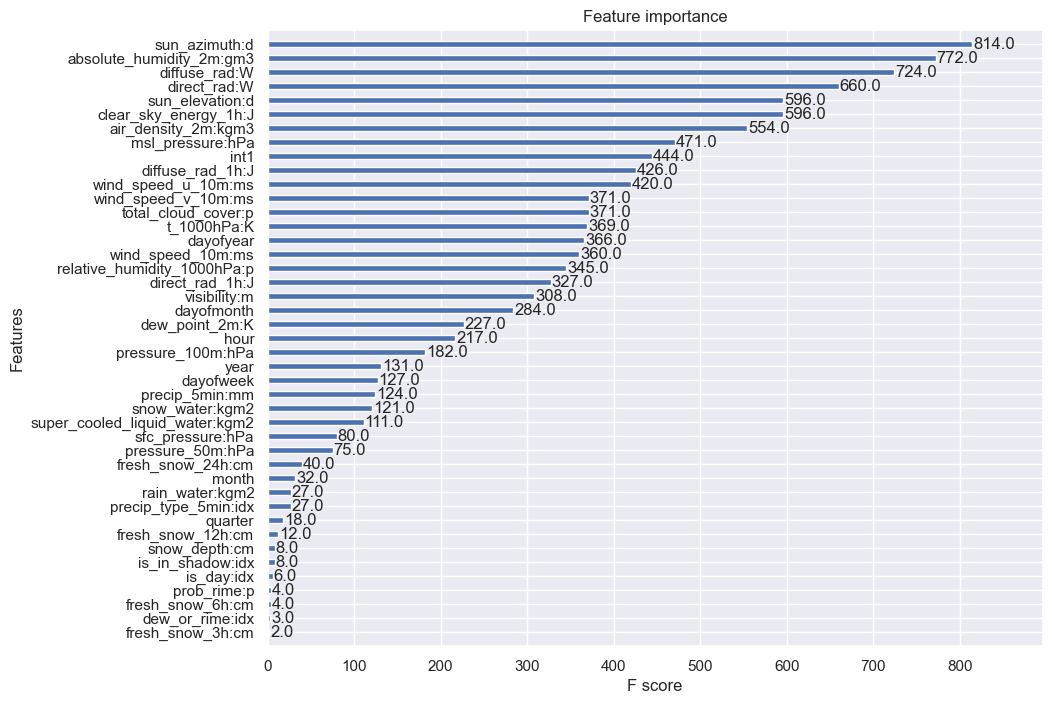

In [381]:
fig, ax = plt.subplots(figsize=(10, 8))

xgb.plot_importance(reg, height=0.4, ax=ax)

In [342]:
reg.get_score(importance_type='weight')

AttributeError: 'XGBRegressor' object has no attribute 'get_score'

In [409]:
results_df = pd.DataFrame(columns=["time", "y", "location"])

for location in ("A", "B", "C"):
    X_train, y_train, _, _ = load_train_test(location)
    X_val = load_val(location)

    y_shift_train = y_train.copy().shift(1)
    y_shift_train.drop(y_shift_train.head(1).index, inplace=True) 

    X_shift_train = X_train.copy()
    X_shift_train.drop(X_shift_train.head(1).index, inplace=True) 


    train_time_features = create_time_feature(X_shift_train.copy())
    test_time_features = create_time_feature(X_val.copy())

    train_time_features["int1"] = train_time_features["clear_sky_rad:W"] * (100 - train_time_features["effective_cloud_cover:p"])
    train_time_features = train_time_features.drop(columns=["effective_cloud_cover:p", "clear_sky_rad:W"])

    test_time_features["int1"] = test_time_features["clear_sky_rad:W"] * (100 - test_time_features["effective_cloud_cover:p"])
    test_time_features = test_time_features.drop(columns=["effective_cloud_cover:p", "clear_sky_rad:W"])

    reg = xgb.XGBRegressor(
        max_depth=7,
        colsample_bytree=0.8,
        eta=0.1,
        n_estimators=90,
        reg_alpha=0.01,
        reg_lambda=0.01
    )
    
    reg.fit(train_time_features, y_shift_train, verbose=False)

    tmp_df = pd.DataFrame(columns=["time", "y", "location"])

    tmp_df["y"] = reg.predict(test_time_features)
    tmp_df["time"] = test_time_features.index
    tmp_df["location"] = location

    results_df = pd.concat([results_df, tmp_df])

In [410]:
output = results_df[results_df.time.isin(np.array(load_val_dates()))]
output = output.reset_index().reset_index().rename(columns={"level_0": "id", "y": "prediction"})[["id", "prediction"]]

In [411]:
output.to_csv("submission.csv", index=False)

In [23]:
A = load_val("A")
B = load_val("B")
C = load_val("C")

A.shape[0] + B.shape[0] + C.shape[0]

4608

In [26]:
results_df = pd.DataFrame(results)
results_df.to_csv¨


,0
0,-6.915474
1,-0.827432
2,12.404133
3,81.764900
4,317.078827
...,...
4603,354.416016
4604,77.945442
4605,22.963306
4606,25.295185


In [25]:
results

array([-6.91547394, -0.82743216, 12.40413284, ..., 22.96330643,
       25.29518509, 32.27764893])

array([], dtype=float64)